In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random

2024-06-04 10:57:58.569838: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 10:57:59.307550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print('Image(Train):', len(os.listdir('Downloads/archive/data/training_images')))
print('Image(Test):', len(os.listdir('Downloads/archive/data/testing_images')))

Image(Train): 1001
Image(Test): 175


In [4]:
# Define the file path
file_path = 'Downloads/archive/data/train_solution_bounding_boxes (1).csv'

# Load the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(data.head())

             image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422


Photo shape: (380, 676, 3)
Name, xmin, ymin, xmax, ymax: Pandas(image='vid_4_1000.jpg', xmin=281.2590449, ymin=187.0350708, xmax=327.7279305, ymax=223.225547)


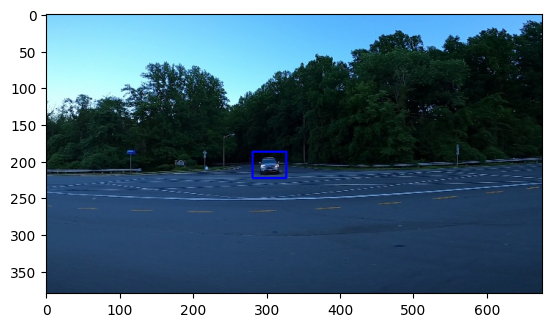

In [5]:
# Directory containing the images
image_dir = 'Downloads/archive/data/training_images/'

# Iterate through each row in the DataFrame
for row in data.itertuples(index=False):
    # Load the image
    image_path = os.path.join(image_dir, row[0])
    photo = cv2.imread(image_path)

    # Print image shape and bounding box coordinates
    print('Photo shape:', photo.shape)
    print('Name, xmin, ymin, xmax, ymax:', row)

    # Extract bounding box coordinates
    xmin, ymin, xmax, ymax = int(row[1]), int(row[2]), int(row[3]), int(row[4])

    # Draw bounding box
    color = (255, 0, 0)  # BGR color format (blue)
    thickness = 2
    cv2.rectangle(photo, (xmin, ymin), (xmax, ymax), color, thickness)

    # Display the image with bounding box
    plt.imshow(cv2.cvtColor(photo, cv2.COLOR_BGR2RGB))
    plt.show()

    # Break the loop after displaying one image
    break

Image shape: (224, 224, 3)
Number of possible bounding boxes: 213


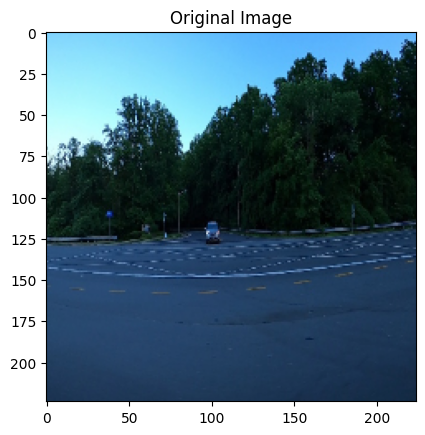

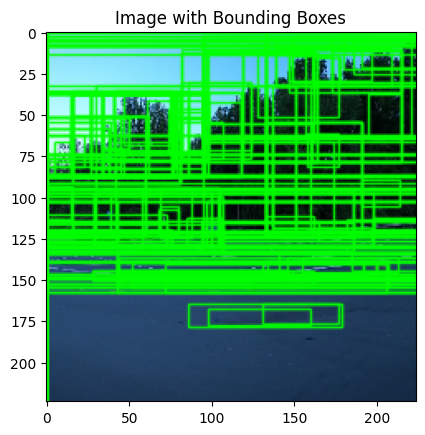

In [6]:
# Load the image
image_path = 'Downloads/archive/data/training_images/vid_4_1000.jpg'
im = cv2.imread(image_path)

# Resize the image
im = cv2.resize(im, (224, 224))

# Display the original image
plt.figure()
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

# Create Selective Search segmentation object
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# Set the base image
ss.setBaseImage(im)

# Switch to fast mode
ss.switchToSelectiveSearchFast()

# Run selective search segmentation
rects = ss.process()

print('Image shape:', im.shape)
print('Number of possible bounding boxes:', len(rects))

# Draw bounding boxes on the image
im_out = im.copy()
for x, y, w, h in rects:
    cv2.rectangle(im_out, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

# Display the image with bounding boxes
plt.figure()
plt.imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB))
plt.title("Image with Bounding Boxes")

plt.show()

In [7]:
def get_iou(bb1, bb2):

    # Check bounding box coordinates validity
    assert bb1['x1'] < bb1['x2'] and bb1['y1'] < bb1['y2'], "Invalid bounding box 1 coordinates"
    assert bb2['x1'] < bb2['x2'] and bb2['y1'] < bb2['y2'], "Invalid bounding box 2 coordinates"

    # Calculate intersection coordinates
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    # Check if there's no intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate intersection area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    # Calculate bounding box areas
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # Calculate IoU
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    # Ensure IoU is within [0, 1]
    assert 0.0 <= iou <= 1.0, "IoU calculation out of range"

    return iou


In [ ]:
image_liste=[]
k=0
l=0
z=0 #Loading
for a in pd.read_csv('Downloads/archive/data/train_solution_bounding_boxes (1).csv').values:
  Name,xmin,ymin,xmax,ymax=a
  # Define the ground truth bounding box
  bb1={
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
  try:
    img=cv2.imread('Downloads/archive/data/training_images/'+Name)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    for i in rects:
      x, y, w, h = i # Selective bounty boxxes
      bb2={'x1':x,
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
      img1=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']] # Crop img
      img1_shape=cv2.resize(img1,(224,224))

      if 0.5<get_iou(bb1,bb2):
        image_liste.append([img1_shape,1])
        k+=1
      else:
        image_liste.append([img1_shape,0])
        l+=1
  except Exception as e:
    print(e)
  z+=1
  print(Name,z,len(rects))

vid_4_1000.jpg 1 1101
vid_4_10000.jpg 2 1456
vid_4_10040.jpg 3 1403
vid_4_10020.jpg 4 1489
vid_4_10060.jpg 5 1315
vid_4_10100.jpg 6 1537
vid_4_10120.jpg 7 1430
vid_4_10140.jpg 8 1544
vid_4_1020.jpg 9 1117
vid_4_1040.jpg 10 1146
vid_4_10480.jpg 11 1663
vid_4_10500.jpg 12 1815
vid_4_10520.jpg 13 1725
vid_4_1060.jpg 14 1251
vid_4_10960.jpg 15 1894
vid_4_10980.jpg 16 1676
vid_4_11000.jpg 17 1754
vid_4_11020.jpg 18 1553
vid_4_11240.jpg 19 1779
vid_4_11260.jpg 20 1863
vid_4_11280.jpg 21 1846
vid_4_11380.jpg 22 1884
vid_4_11400.jpg 23 1929
vid_4_11420.jpg 24 1925
vid_4_11440.jpg 25 1880
vid_4_11900.jpg 26 1801
vid_4_11880.jpg 27 1824
vid_4_11920.jpg 28 1857
vid_4_11940.jpg 29 1947
vid_4_11960.jpg 30 1932
vid_4_11980.jpg 31 1970
vid_4_12000.jpg 32 1901
vid_4_12040.jpg 33 1979
vid_4_12100.jpg 34 1971
vid_4_12060.jpg 35 1879
vid_4_12080.jpg 36 1870
vid_4_12120.jpg 37 1821
vid_4_12140.jpg 38 1632
vid_4_12140.jpg 39 1632
vid_4_12160.jpg 40 1682
vid_4_12160.jpg 41 1682
vid_4_12160.jpg 42 1682
vid_4

In [ ]:
num_images = len(image_liste)
print(f"The number of processed images is: {num_images}")

In [ ]:
data = [features for features, _ in image_liste]
data_label = [label for _, label in image_liste]

In [ ]:
print(len(data),len(data_label))

In [ ]:
random_index = random.randint(1, len(data) - 1)

# Print the class label and shape of the image at the random index
print('Class:', data_label[random_index])
print('Image shape:', data[random_index].shape)

# Display the image
plt.imshow(data[random_index])
plt.title(f'Class: {data_label[random_index]}')
plt.axis('off')  # Hide axis
plt.show()

In [12]:
data=np.asarray(data)
data_label=np.asarray(data_label) 

In [48]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# Define the ResNet50 base model with pre-trained weights and desired input shape
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent training
base_model.trainable = False

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(data, data_label, test_size=0.15, random_state=42)

# Construct the model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])


In [49]:
# Loop through layers of the base model and print their names and whether they are trainable
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, '-', layer.trainable)




0 input_layer_4 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_c

In [50]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the callback to save the best model weights
checkpoint = ModelCheckpoint(filepath='best_model_weights.weights.h5',  # Filepath to save the weights
                             save_best_only=True,  # Save only the best model
                             monitor='val_accuracy',  # Monitor validation accuracy
                             mode='max',  
                             save_weights_only=True)  # Save only the weights

# Train the model
history = model.fit(x_train, y_train, 
                    epochs=10, 
                    validation_data=(x_val, y_val), 
                    callbacks=[checkpoint])


Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.9175 - loss: 0.2135 - val_accuracy: 0.9780 - val_loss: 0.0765
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.9732 - loss: 0.0970 - val_accuracy: 0.9786 - val_loss: 0.0723
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.9756 - loss: 0.0818 - val_accuracy: 0.9805 - val_loss: 0.0763
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - accuracy: 0.9769 - loss: 0.0838 - val_accuracy: 0.9811 - val_loss: 0.0721
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - accuracy: 0.9816 - loss: 0.0636 - val_accuracy: 0.9830 - val_loss: 0.0802
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - accuracy: 0.9833 - loss: 0.0610 - val_accuracy: 0.9754 - val_loss: 0.0901
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - accuracy: 0.9856 - loss: 0.0509 - val_accuracy: 0.9792 - val_loss: 0.0798
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - accuracy: 0.9855 - loss: 0.0472 -

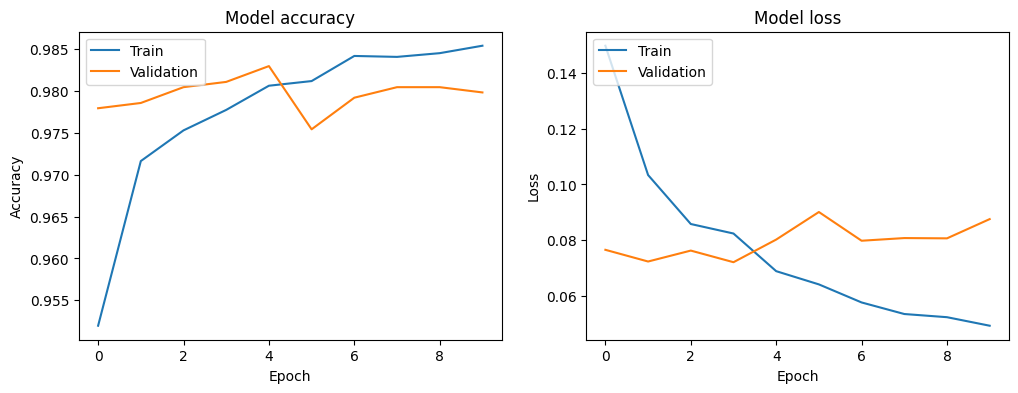

In [52]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def perform_object_detection(image, model, threshold=0.6, nms_threshold=0.4):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    car_boxes = []
    scores = []
    for x, y, w, h in rects:
        bounding_box = [x, y, x + w, y + h]  # Change to list format
        try:
            assert bounding_box[0] < bounding_box[2]
            assert bounding_box[1] < bounding_box[3]
            
            img_data = image[bounding_box[1]:bounding_box[3], bounding_box[0]:bounding_box[2]]
            img_data = cv2.resize(img_data, (224, 224))
            
            prediction = model.predict(img_data.reshape(1, 224, 224, 3))
            score = float(prediction.item())  # Convert prediction score to float
            if score > threshold:
                car_boxes.append(bounding_box)
                scores.append(score)
        except Exception as e:
            print('Error processing bounding box:', e)
    
    # Apply Non-Maximum Suppression
    indices = cv2.dnn.NMSBoxes(car_boxes, scores, threshold, nms_threshold)
    selected_boxes = [car_boxes[idx] for idx in indices.flatten()]
    
    return selected_boxes


def draw_boxes(image, boxes):
    for box in boxes:
        x1, y1, x2, y2 = box  # Unpack the bounding box coordinates
        pt1 = (x1, y1)
        pt2 = (x2, y2)
        cv2.rectangle(image, pt1, pt2, (255, 0, 0), 2)
    
    return image

# Load image
photo_path = 'Downloads/archive/data/training_images/vid_4_29920.jpg'
deneme_img = cv2.imread(photo_path)

# Check if image is loaded successfully
if deneme_img is None:
    print("Error: Unable to load image.")
else:
    # Assuming 'model' is defined elsewhere
    car_boxes = perform_object_detection(deneme_img, model)

    # Draw bounding boxes
    image_with_boxes = draw_boxes(deneme_img.copy(), car_boxes)

    # Display the image with the bounding boxes
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title(f'Number of Boxes: {len(car_boxes)}')
    plt.show()


NameError: name 'model' is not defined

Selected model: CNN


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.10/tkinter/__init__.py", line 1921, in __call__
    return self.func(*args)
  File "/tmp/ipykernel_3602/3174090023.py", line 94, in open_photo_explorer
    image_do(file_path)
  File "/tmp/ipykernel_3602/2553888568.py", line 9, in image_do
    car_boxes = perform_object_detection(deneme_img, model)
NameError: name 'model' is not defined
